In [41]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 20000
DROPOUT = 0.5
BATCH_SIZE = 50
VALIDATION_SIZE = 2000
IMAGE_TO_DISPLAY = 10
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
train = pd.read_csv('train.csv')

In [42]:
images = train.iloc[:,1:].values.astype(np.float)
images = np.multiply(images, 1.0/255.0)
print(images.shape)
print(images[IMAGE_TO_DISPLAY])

(42000, 784)
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0

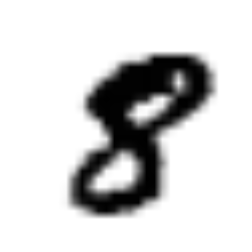

In [43]:
def display(img):
    one_image = img.reshape(IMAGE_WIDTH,IMAGE_HEIGHT)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
display(images[IMAGE_TO_DISPLAY])

In [50]:
labels_flat = train[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
print(labels_count)
print(labels_flat[IMAGE_TO_DISPLAY])

10
8


In [51]:
def dense_to_one_hot(labels_dense, num_classes):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot
labels = dense_to_one_hot(train[[0]].values.ravel(), 10)
labels = labels.astype(np.uint8)
print(labels[IMAGE_TO_DISPLAY])

[0 0 0 0 0 0 0 0 1 0]


In [52]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print(train_images.shape)
print(validation_images.shape)

(40000, 784)
(2000, 784)


In [53]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [54]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [55]:
# images
x = tf.placeholder('float', shape=[None, IMAGE_WIDTH*IMAGE_HEIGHT])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [58]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,IMAGE_WIDTH , IMAGE_HEIGHT,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, IMAGE_HEIGHT, IMAGE_WIDTH, 4 ,8))
#print(layer1.get_shape())

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
#print(layer1.get_shape())

layer1 = tf.reshape(layer1, (-1, IMAGE_HEIGHT*4, IMAGE_WIDTH*8)) 
#print(layer1.get_shape())

In [60]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

In [61]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [66]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [67]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
predict = tf.argmax(y,1)

In [72]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [73]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x109d785d0>> ignored


In [76]:
for i in range(TRAINING_ITERATIONS):
  batch_xs,batch_ys = next_batch(BATCH_SIZE)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images[0:BATCH_SIZE], 
                                                   y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})
    print("step %d, validation accuracy %g"%(i, validation_accuracy))
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

step 0, training accuracy 0.96
step 0, validation accuracy 0.96
step 100, training accuracy 0.94
step 100, validation accuracy 0.98
step 200, training accuracy 0.96
step 200, validation accuracy 0.98
step 300, training accuracy 0.98
step 300, validation accuracy 0.98
step 400, training accuracy 0.96
step 400, validation accuracy 0.98
step 500, training accuracy 0.98
step 500, validation accuracy 0.98
step 600, training accuracy 1
step 600, validation accuracy 0.98
step 700, training accuracy 0.96
step 700, validation accuracy 1
step 800, training accuracy 0.98
step 800, validation accuracy 1
step 900, training accuracy 1
step 900, validation accuracy 0.98
step 1000, training accuracy 1
step 1000, validation accuracy 0.98
step 1100, training accuracy 1
step 1100, validation accuracy 1
step 1200, training accuracy 0.98
step 1200, validation accuracy 1
step 1300, training accuracy 0.96
step 1300, validation accuracy 0.98
step 1400, training accuracy 1
step 1400, validation accuracy 0.98
s

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0


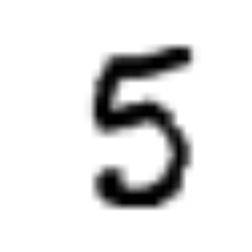

In [78]:
# read test data from CSV file 
test_images = pd.read_csv('test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')